<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2018, семинар 7 </span>

<span style="color:blue; font-size: 12pt">by Ilya Irkhin</span>

In [37]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import heapq
from matplotlib import pyplot as plt
%matplotlib inline

# Задача классификации текстов

Задача классификации текстов заключается в том, чтобы определить по документу его класс.
В данном случае предлагается рассмотреть в качестве документов - письма, заранее отклассифицированных по 20 темам.

In [2]:
all_categories = fetch_20newsgroups().target_names
all_categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Возьмём всего 3 темы, но из одного раздела (документы из близких тем сложнее отличать друг от друга)

In [3]:
categories = [
    'sci.electronics',
    'sci.space',
    'sci.med'
]

train_data = fetch_20newsgroups(subset='train',
                                categories=categories,
                                remove=('headers', 'footers', 'quotes'))

test_data = fetch_20newsgroups(subset='test',
                               categories=categories,
                               remove=('headers', 'footers', 'quotes'))

## Векторизация текстов
Для векторизации текстов воспользуемся CountVectorizer, он представляет документ как мешок слов. Можно всячески варировать извлечение признаков (убирать редкие слова, убирать частые слова, убирать слова общей лексики, брать биграмы и т.д.)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [6]:
count_vectorizer = CountVectorizer(min_df=5, ngram_range=(1, 2)) 

In [7]:
sparse_feature_matrix = count_vectorizer.fit_transform(train_data.data)
sparse_feature_matrix

<1778x10885 sparse matrix of type '<class 'numpy.int64'>'
	with 216486 stored elements in Compressed Sparse Row format>

In [8]:
num_2_words = {
    v: k
    for k, v in count_vectorizer.vocabulary_.items()
}

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

Обучим логистическую регрессию для предсказания темы документа

In [85]:
algo = LogisticRegression(C=0.00001)
algo.fit(sparse_feature_matrix, train_data.target)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Слова с наибольшим положительным весом, являются характерными словами темы

In [11]:
W = algo.coef_.shape[1]
for c in algo.classes_:
    topic_words = [
        num_2_words[w_num]
        for w_num in heapq.nlargest(10, range(W), key=lambda w: algo.coef_[c, w])
    ]
    print(',  '.join(topic_words))


circuit,  electronics,  power,  chips,  parts,  them,  the number,  used,  tv,  ve
msg,  medical,  my,  blood,  disease,  doctor,  health,  treatment,  your,  needles
space,  orbit,  nasa,  thanks for,  launch,  earth,  sorry,  moon,  spacecraft,  solar


Сравним качество на трейне и на отложенном тесте

In [86]:
algo.fit(sparse_feature_matrix, train_data.target)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
accuracy_score(algo.predict(sparse_feature_matrix), train_data.target)

0.50393700787401574

In [88]:
accuracy_score(algo.predict(count_vectorizer.transform(test_data.data)), test_data.target)

0.45815722738799664

** Точность на тесте намного ниже! **
** Вопрос: в чём причина? ** 

(array([  1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   3.50000000e+01,   1.08150000e+04,
          2.30000000e+01]),
 array([-0.00849629, -0.00750721, -0.00651814, -0.00552907, -0.00453999,
        -0.00355092, -0.00256185, -0.00157277, -0.0005837 ,  0.00040538,
         0.00139445]),
 <a list of 10 Patch objects>)

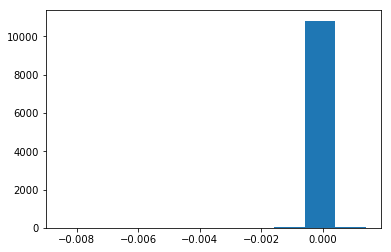

In [106]:
plt.hist(algo.coef_[0])

** Какую выбрать метрику для регуляризации? **

In [116]:
algo = LogisticRegression(penalty='l1', C=0.1)
arr = cross_val_score(algo, sparse_feature_matrix, train_data.target, cv=5, scoring='accuracy')
print(arr)
print(np.mean(arr))

[ 0.72829132  0.74719101  0.73033708  0.74647887  0.71186441]
0.732832537287


In [117]:
algo.fit(sparse_feature_matrix, train_data.target)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [118]:
accuracy_score(algo.predict(sparse_feature_matrix), train_data.target)

0.79358830146231718

In [119]:
accuracy_score(algo.predict(count_vectorizer.transform(test_data.data)), test_data.target)

0.68131868131868134

Подберём оптимальное значение параметра регуляризации

In [39]:
lr_grid = {'C': np.concatenate((np.linspace(.1, .9, 9), np.linspace(10, 200, 20))), dtype='float')}
%time gs = GridSearchCV(LogisticRegression(penalty='l1'), lr_grid, scoring='accuracy', cv=5, n_jobs=5)
gs.fit(sparse_feature_matrix, train_data.target)
gs.best_params_, gs.best_score_

({'C': 9}, 0.8098987626546682)

Wall time: 43.1 ms


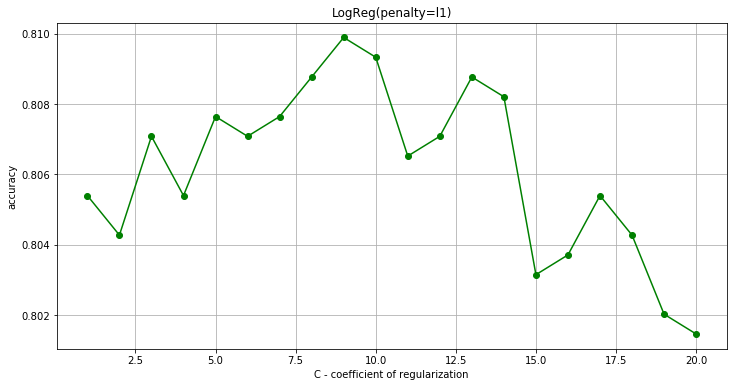

In [41]:
def grid_plot(x, y, x_label, title, y_label='accuracy'):
    plt.figure(figsize=(12, 6))
    plt.grid(True),
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
grid_plot(lr_grid['C'], gs.cv_results_['mean_test_score'], 'C - coefficient of regularization', 'LogReg(penalty=l1)')

In [44]:
lr_final = LogisticRegression(penalty='l1', C=9)
%time lr_final.fit(sparse_feature_matrix, train_data.target)

Wall time: 17.7 s


LogisticRegression(C=9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
accuracy_score(lr_final.predict(sparse_feature_matrix), train_data.target)

0.98087739032620924

In [45]:
accuracy_score(lr_final.predict(count_vectorizer.transform(test_data.data)), test_data.target)

0.75486052409129334

## Регуляризация вместе с векторизацией признаков
Чтобы не делать векторизацию и обучение раздельно, есть удобный класс Pipeline. Он позволяет объединить в цепочку последовательность действий

In [69]:
from sklearn.pipeline import Pipeline

In [70]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(min_df=5, ngram_range=(1, 2))),
    ("algo", LogisticRegression())
])

In [71]:
pipeline.fit(train_data.data, train_data.target)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [72]:
accuracy_score(pipeline.predict(train_data.data), train_data.target)

0.98031496062992129

In [73]:
accuracy_score(pipeline.predict(test_data.data), test_data.target)

0.79289940828402372

Значения ровно такие же как мы получали ранее, делая шаги раздельно.

In [74]:
from sklearn.pipeline import make_pipeline

При кроссвалидации нужно, чтобы CountVectorizer не обучался на тесте (иначе объекты становятся зависимыми). Pipeline позволяет это просто сделать.

In [75]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring='accuracy')
print(arr)
print(np.mean(arr))

[ 0.83753501  0.84550562  0.82303371  0.83943662  0.83050847]
0.835203886829


В Pipeline можно добавлять новые шаги препроцессинга данных

In [76]:
from sklearn.feature_extraction.text import TfidfTransformer

In [77]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), TfidfTransformer(), LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring='accuracy')
print(arr)
print(np.mean(arr))

[ 0.87114846  0.87078652  0.84831461  0.85633803  0.83898305]
0.857114132399


In [78]:
pipeline.fit(train_data.data, train_data.target)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [79]:
accuracy_score(pipeline.predict(train_data.data), train_data.target)

0.96962879640044997

In [80]:
accuracy_score(pipeline.predict(test_data.data), test_data.target)

0.82417582417582413

Качество стало немного лучше

# <span style="color:orange; font-size: 12pt">Задание (Опционально)</span> 

1. Поиграйтесь с параметрами регуляризации, параметрами CountVectorizer и TfidfTransformer, чтобы получить максимальное качество.
2. Постройте список важных слов и словосочетаний для каждой темы (на основе значений коэффициентов)